Importez les données et affichez les 5 premières lignes.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

d=pd.read_csv('content.csv',sep='\t')
d.head()
len(d)

2198

1- Les données : 
Filtrez les Usernames pour conservez ceux qui apparaissent au moins 10 fois dans la base de données, et gardez seulement 10 itérations par Username.

In [4]:
## garder seulement les Usernames apparaissant plus de 10 fois et selement les 10 premières apparitions des Usernames (>=10)
import csv
def Tri_10_user(dataframe):
    for i in range(1,len(dataframe['Username'].unique())):
        if dataframe['Username'].value_counts()[i] < 10:
            dataframe = dataframe[dataframe['Username'] != dataframe['Username'].unique()[i]]
    dataframe = dataframe.groupby('Username', sort=False).head(10) 
    return dataframe

d=(Tri_10_user(d))

print(d['Username'].value_counts()) # on a bien 10 enregistrements par Username
d.to_csv('content_10.csv', sep='\t', index=False)


Username
1      10
70     10
81     10
80     10
79     10
       ..
34     10
33     10
32     10
31     10
110    10
Name: count, Length: 110, dtype: int64


2- Les scores : Définition de 50% de référence et 50% comme échantillon

In [5]:
def separation(d):
    d1, d2 = d.groupby('Username',sort = False).head(5), d.groupby('Username',sort=False).tail(5)
    return d1, d2

d1, d2 = separation(d)
len(d1), len(d2)
d1["Username"].value_counts(), d2["Username"].value_counts()


(Username
 1      5
 70     5
 81     5
 80     5
 79     5
       ..
 34     5
 33     5
 32     5
 31     5
 110    5
 Name: count, Length: 110, dtype: int64,
 Username
 1      5
 70     5
 81     5
 80     5
 79     5
       ..
 34     5
 33     5
 32     5
 31     5
 110    5
 Name: count, Length: 110, dtype: int64)

3- Normalisation des données

In [6]:
# d1_mean = np.mean(d1,axis=1) #mettre les colonnes numériques #axis=1 pour les lignes donc par individu 
# d1_sd = np.std(d1,axis=1)

In [7]:
def distance(ech1, ech2):
    
    mesures1 = pd.to_numeric(ech1[5:])
    mesures2 = pd.to_numeric(ech2[5:])
    
    
    # Calculer la distance euclidienne entre les mesures
    return np.linalg.norm(mesures1 - mesures2)

Distance et score de similarité(moyen)

In [8]:
# distance(d1.loc[1],d1.loc[2]) #test

def score(refs, test):
    distances = []
    for i in refs:
        ref = d1.loc[i]
        distances.append(distance(ref, test))
    return np.mean(distances)


score((0,1,2,3,4),d2.loc[5]) #test


377.48755065128995

FAR FRR au seuil basé sur la moyenne intra individu 

In [9]:
def score_intra(id):
    scores = dict()
    for i in len(d1["Username"].unique()):
        scores[i] = min(score(d1.loc[i],d2.loc[i]))
    return scores


In [10]:
def FAR(refs, seuil):
    for i in range(len(d2)):
        if score(refs,d2.loc[i]) < seuil:
            return False
    
    return 


#comment mettre les noms de lignes de 1 à leng(d1) dans d1
d1.index = range(len(d1))
d2.index = range(len(d2))
d1.index

RangeIndex(start=0, stop=550, step=1)

In [73]:
#testez les distances entre chaque echantillon de meme Username dans d1
import math
distances = list()
for i in range(len(d1)):
    for j in range(5):
        distances.append(distance(d1.loc[i],d1.loc[j]))
        # print("distance entre ",i," et ",j, " : ", distance(d1.loc[i],d1.loc[j]))        #affichez les distances 



In [14]:
import pandas as pd
import numpy as np

def calculate_intra_user_thresholds(d1):
    """
    Calcule les seuils intra-utilisateurs basés sur les distances moyennes entre leurs échantillons dans d1.
    """
    thresholds = {}
    for username, group in d1.groupby('Username'):
        distances = []
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                distance = np.linalg.norm(pd.to_numeric(group.iloc[i][5:]) - pd.to_numeric(group.iloc[j][5:]))
                distances.append(distance)
        if distances:
            thresholds[username] = np.mean(distances)
    return thresholds

def FAR(d1, d2, thresholds):
    false_accepts = 0
    total_comparisons = 0
    
    for i, row_i in d2.iterrows():
        test_user = row_i['Username']
        test_measurements = pd.to_numeric(row_i[5:])
        
        for ref_user, ref_threshold in thresholds.items():
            if test_user != ref_user:  # Comparer seulement avec d'autres utilisateurs
                for _, ref_row in d1[d1['Username'] == ref_user].iterrows():
                    ref_measurements = pd.to_numeric(ref_row[5:])
                    distance = np.linalg.norm(ref_measurements - test_measurements)
                    
                    if distance < ref_threshold:
                        false_accepts += 1
                    total_comparisons += 1
    
    far = false_accepts / total_comparisons if total_comparisons > 0 else 0
    return far

# Préparation des dataframes d1 et d2
# d1, d2 = ...

# Calcul des seuils intra-utilisateurs pour d1
thresholds = calculate_intra_user_thresholds(d1)

# Calcul du FAR
far_value = FAR(d1, d2, thresholds)
print(f"FAR: {far_value}")

FAR: 0.4029124270225188


In [16]:
def FRR(d1, d2, thresholds):
    false_rejections = 0
    total_tests = 0
    
    for test_username, group in d2.groupby('Username'):
        if test_username in thresholds:  # Assurez-vous que l'utilisateur est dans d1 et a un seuil calculé
            ref_threshold = thresholds[test_username]
            for i, test_row in group.iterrows():
                test_measurements = pd.to_numeric(test_row[5:])
                distances = []
                
                # Calculer les distances seulement avec les échantillons de d1 pour le même utilisateur
                for _, ref_row in d1[d1['Username'] == test_username].iterrows():
                    ref_measurements = pd.to_numeric(ref_row[5:])
                    distance = np.linalg.norm(ref_measurements - test_measurements)
                    distances.append(distance)
                
                # Si toutes les distances sont supérieures au seuil, c'est une fausse réjection
                if all(d > ref_threshold for d in distances):
                    false_rejections += 1
                total_tests += 1
    
    frr = false_rejections / total_tests if total_tests > 0 else 0
    return frr

# Utiliser les mêmes seuils intra-utilisateurs calculés précédemment
# thresholds = calculate_intra_user_thresholds(d1)

# Calcul du FRR
frr_value = FRR(d1, d2, thresholds)
print(f"FRR: {frr_value}")


FRR: 0.09454545454545454


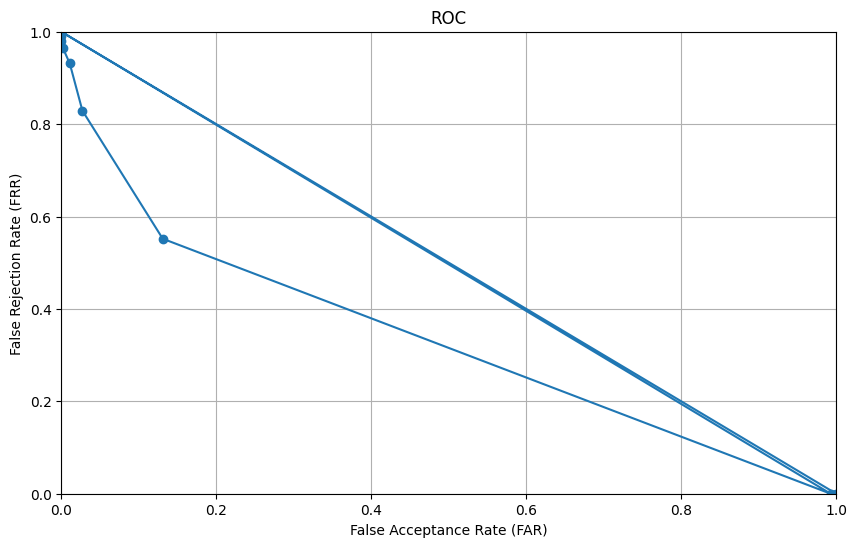

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_distance_scores(d1):
    """
    Calcule tous les scores de distance entre les échantillons de d1.
    """
    scores = []
    for username, group in d1.groupby('Username'):
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                distance = np.linalg.norm(pd.to_numeric(group.iloc[i][5:]) - pd.to_numeric(group.iloc[j][5:]))
                scores.append(distance)
    return scores

########## 10 minutes d'execution environ
def ROC(d1, d2):
    # Calculer tous les scores de distance pour déterminer les seuils
    distance_scores = calculate_distance_scores(d1)
    min_score, max_score = min(distance_scores), max(distance_scores)
    
    # Inclure les points (0,1) et (1,0)
    far_values = [1]
    frr_values = [0]
    
    # Calculer FAR et FRR pour une série de seuils
    for threshold in np.linspace(min_score, max_score, 10):
        far = FAR(d1, d2, {k: threshold for k in thresholds})
        frr = FRR(d1, d2, {k: threshold for k in thresholds})
        far_values.append(far)
        frr_values.append(frr)
    
    # Ajouter les points extrêmes de la courbe ROC
    far_values.append(0)
    frr_values.append(1)
    
    return far_values, frr_values

# Calcul de la courbe ROC
far_values, frr_values = ROC(d1, d2)

# Tracé de la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(frr_values, far_values, marker='o')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('ROC')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [ ]:
def AUC(far_values, frr_values):
    auc = 0
    for i in range(1, len(far_values)):
        auc += (far_values[i] - far_values[i - 1]) * (frr_values[i] + frr_values[i - 1]) / 2
    return auc

AUC(far_values, frr_values)
# min(thresholds)
# min(thresholds.values())
# max((thresholds).values())
# min_value = min(thresholds.values())
# max_value = max(thresholds.values())


IndexError: list index out of range

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

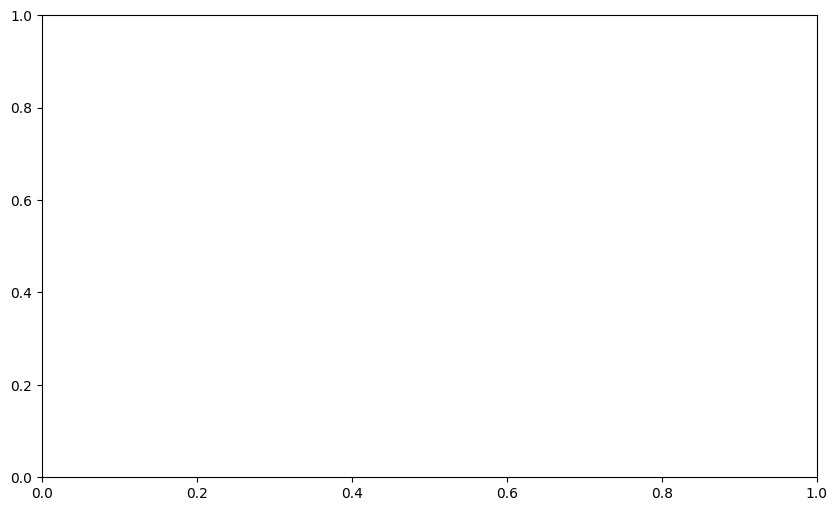

In [69]:

# Tracé de la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(frr_values, far_values, marker='o')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('ROC')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.show()

